<a href="https://colab.research.google.com/github/MadhurimaPaul-87/Research_Plan_Makaut/blob/main/Chapter2_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# Preprocessing Layer
class PreprocessingLayer(nn.Module):
    def __init__(self, in_channels, out_channels=32):
        super(PreprocessingLayer, self).__init__()
        self.conv1d = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.avg_pool = nn.AvgPool1d(kernel_size=2)

    def forward(self, x):
        x = self.conv1d(x)
        x = F.relu(x)
        x = self.avg_pool(x)
        return x

In [4]:
# Local-Global Transformer Block
class LGTB(nn.Module):
    def __init__(self, channels):
        super(LGTB, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(channels),
            nn.ReLU()
        )
        self.transformer = nn.TransformerEncoderLayer(d_model=channels, nhead=8, dim_feedforward=channels*2)

    def forward(self, x):
        local_feat = self.conv(x)
        global_feat = self.transformer(local_feat.permute(2, 0, 1))
        return global_feat.permute(1, 2, 0)


In [5]:
# Dual Branch Network
class DualBranch(nn.Module):
    def __init__(self, channels):
        super(DualBranch, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(channels),
            nn.ReLU()
        )
        self.lgtb = LGTB(channels)

    def forward(self, x):
        x = self.cnn(x)
        x = self.lgtb(x)
        return x

In [6]:
# Absolute root fix: dynamically compute input feature size for GatedFusion Linear layer

class GatedFusion(nn.Module):
    def __init__(self, channels):
        super(GatedFusion, self).__init__()
        self.fc = nn.Linear(channels * 2, channels)

    def forward(self, clean, noise):
        batch_size, channels, seq_len = clean.size()
        combined = torch.cat([clean, noise], dim=1)         # (batch, 2*channels, seq_len)
        combined = combined.permute(0, 2, 1)                # (batch, seq_len, 2*channels)
        combined = combined.reshape(-1, combined.shape[-1]) # (batch*seq_len, 2*channels)
        mask = self.fc(combined)                            # (batch*seq_len, channels)
        mask = torch.tanh(mask)
        mask = mask.view(batch_size, seq_len, channels)     # (batch, seq_len, channels)
        mask = mask.permute(0, 2, 1)                        # (batch, channels, seq_len)
        fused = clean * mask + noise * (1 - mask)
        return fused

In [7]:
class ART_DHCTNet(nn.Module):
    def __init__(self, in_channels, seq_len): # Added seq_len as an argument
        super(ART_DHCTNet, self).__init__()
        self.preprocessing = PreprocessingLayer(in_channels)
        self.clean_branch = DualBranch(32)
        self.artifact_branch = DualBranch(32)
        self.fusion = GatedFusion(32)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=32, nhead=8, dim_feedforward=64),
            num_layers=4
        )
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=32, nhead=8, dim_feedforward=64),
            num_layers=4
        )
        self.final_linear = nn.Linear(32, in_channels)
        self.seq_len = seq_len # Store seq_len as an attribute

    def forward(self, x):
        x = self.preprocessing(x)  # (batch, 32, seq_len/2)
        clean_feat = self.clean_branch(x)
        artifact_feat = self.artifact_branch(x)
        fused_feat = self.fusion(clean_feat, artifact_feat)

        fused_feat = fused_feat.permute(2, 0, 1)  # (seq_len/2, batch, channels)
        encoded = self.encoder(fused_feat)
        decoded = self.decoder(encoded, encoded)
        decoded = decoded.permute(1, 2, 0)  # (batch, channels, seq_len/2)

        out = self.final_linear(decoded.permute(0, 2, 1))  # (batch, seq_len/2, in_channels)
        out = out.permute(0, 2, 1)  # (batch, in_channels, seq_len/2)

        out = F.interpolate(out, size=(self.seq_len), mode='linear', align_corners=True)  # Upsample back to original length using self.seq_len
        return out



In [8]:
# Loss Function
class TotalLoss(nn.Module):
    def __init__(self, lambda1=0.1, lambda2=0.01):
        super(TotalLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.lambda1 = lambda1
        self.lambda2 = lambda2

    def forward(self, output, target, features_real=None, features_fake=None, adversarial_loss=None):
        loss_mse = self.mse(output, target)
        loss_feature = self.mse(features_fake, features_real) if features_real is not None else 0
        loss_adv = adversarial_loss if adversarial_loss is not None else 0
        total_loss = loss_mse + self.lambda1 * loss_feature + self.lambda2 * loss_adv
        return total_loss

In [9]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


In [10]:
# Custom Dataset for DenoiseNet EEG, EMG, EOG
class EEGDataset(Dataset):
    def __init__(self, eeg_path, emg_path, eog_path, segment_length=512):
        self.eeg = np.load(eeg_path)  # Shape: (n_samples, n_channels, signal_length)
        self.emg = np.load(emg_path)
        self.eog = np.load(eog_path)
        self.segment_length = segment_length

        self.eeg = torch.from_numpy(self.eeg).float()
        self.emg = torch.from_numpy(self.emg).float()
        self.eog = torch.from_numpy(self.eog).float()

        # Check if the data has 3 dimensions. If not, add a channel dimension
        if len(self.eeg.shape) == 2:
            self.eeg = self.eeg.unsqueeze(1)  # Add channel dimension
        if len(self.emg.shape) == 2:
            self.emg = self.emg.unsqueeze(1)  # Add channel dimension
        if len(self.eog.shape) == 2:
            self.eog = self.eog.unsqueeze(1)  # Add channel dimension

        min_len = min(self.eeg.shape[2], self.emg.shape[2], self.eog.shape[2])
        self.eeg = self.eeg[:, :, :min_len]
        self.emg = self.emg[:, :, :min_len]
        self.eog = self.eog[:, :, :min_len]

    def __len__(self):
        return self.eeg.shape[0]

    def __getitem__(self, idx):
        clean_eeg = self.eeg[idx]
        noise = self.emg[idx] + self.eog[idx]
        noisy_eeg = clean_eeg + noise

        return noisy_eeg, clean_eeg

In [11]:
# Instantiate Dataset and DataLoader
eeg_path = '/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/eeg_3400.npy'
emg_path = '/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/emg_3400.npy'
eog_path = '/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/eog_3400.npy'


# Instantiate correctly
dataset = EEGDataset(eeg_path, emg_path, eog_path)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ART_DHCTNet(in_channels=dataset.eeg.shape[1], seq_len=dataset.eeg.shape[2]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = TotalLoss()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [12]:
# Training Loop
def train_model(model, dataloader, optimizer, loss_fn, device, epochs=50):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for noisy_eeg, clean_eeg in dataloader:
            noisy_eeg = noisy_eeg.to(device)
            clean_eeg = clean_eeg.to(device)

            optimizer.zero_grad()
            outputs = model(noisy_eeg)
            loss = loss_fn(outputs, clean_eeg)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.6f}")


In [13]:
# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ART_DHCTNet(in_channels=dataset.eeg.shape[1], seq_len=dataset.eeg.shape[2]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = TotalLoss()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [14]:
# Start Training
train_model(model, dataloader, optimizer, loss_fn, device, epochs=50)

Epoch [1/50] - Loss: 53183.655992
Epoch [2/50] - Loss: 52966.987618
Epoch [3/50] - Loss: 52957.054245
Epoch [4/50] - Loss: 52842.220445
Epoch [5/50] - Loss: 52853.266509
Epoch [6/50] - Loss: 52772.817401
Epoch [7/50] - Loss: 52766.098835
Epoch [8/50] - Loss: 52704.859559
Epoch [9/50] - Loss: 52691.296764
Epoch [10/50] - Loss: 52629.010429
Epoch [11/50] - Loss: 52658.930425
Epoch [12/50] - Loss: 52647.228626
Epoch [13/50] - Loss: 52622.920880
Epoch [14/50] - Loss: 52482.949956
Epoch [15/50] - Loss: 52544.583026
Epoch [16/50] - Loss: 52454.012014
Epoch [17/50] - Loss: 52423.010503
Epoch [18/50] - Loss: 52403.383513
Epoch [19/50] - Loss: 52306.626879
Epoch [20/50] - Loss: 52310.012050
Epoch [21/50] - Loss: 52314.103700
Epoch [22/50] - Loss: 52257.992667
Epoch [23/50] - Loss: 52174.865935
Epoch [24/50] - Loss: 52181.141878
Epoch [25/50] - Loss: 52113.446271
Epoch [26/50] - Loss: 52075.813937
Epoch [27/50] - Loss: 52056.449256
Epoch [28/50] - Loss: 51962.901201
Epoch [29/50] - Loss: 51986.9

In [15]:
import scipy.signal as signal
import numpy as np

In [16]:
# Evaluation Metrics
def calculate_mse(clean, denoised):
    return torch.mean((clean - denoised) ** 2).item()

def calculate_snr_improvement(noisy, clean, denoised):
    noise_before = noisy - clean
    noise_after = denoised - clean
    power_signal = torch.mean(clean ** 2, dim=[1, 2])
    power_noise_before = torch.mean(noise_before ** 2, dim=[1, 2])
    power_noise_after = torch.mean(noise_after ** 2, dim=[1, 2])

    snr_before = 10 * torch.log10(power_signal / power_noise_before)
    snr_after = 10 * torch.log10(power_signal / power_noise_after)
    improvement = torch.mean(snr_after - snr_before).item()
    return improvement

def calculate_psd_similarity(clean, denoised, fs=256):
    batch_size, channels, length = clean.shape
    psd_similarities = []

    for i in range(batch_size):
        similarity_per_channel = []
        for ch in range(channels):
            f_clean, p_clean = signal.welch(clean[i, ch].cpu().numpy(), fs=fs, nperseg=256)
            f_denoised, p_denoised = signal.welch(denoised[i, ch].cpu().numpy(), fs=fs, nperseg=256)

            p_clean /= np.sum(p_clean)
            p_denoised /= np.sum(p_denoised)
            similarity = np.sum(np.sqrt(p_clean * p_denoised))
            similarity_per_channel.append(similarity)

        psd_similarities.append(np.mean(similarity_per_channel))

    return np.mean(psd_similarities)

In [17]:
# Evaluation Function
def evaluate_model(model, dataloader, device):
    model.eval()
    total_mse = 0
    total_snr_improvement = 0
    total_psd_similarity = 0
    num_batches = 0

    with torch.no_grad():
        for noisy_eeg, clean_eeg in dataloader:
            noisy_eeg = noisy_eeg.to(device)
            clean_eeg = clean_eeg.to(device)

            denoised_eeg = model(noisy_eeg)

            total_mse += calculate_mse(clean_eeg, denoised_eeg)
            total_snr_improvement += calculate_snr_improvement(noisy_eeg, clean_eeg, denoised_eeg)
            total_psd_similarity += calculate_psd_similarity(clean_eeg, denoised_eeg)
            num_batches += 1

    avg_mse = total_mse / num_batches
    avg_snr_improvement = total_snr_improvement / num_batches
    avg_psd_similarity = total_psd_similarity / num_batches

    print(f"Evaluation Results:")
    print(f"  - Average MSE: {avg_mse:.6f}")
    print(f"  - Average SNR Improvement: {avg_snr_improvement:.2f} dB")
    print(f"  - Average PSD Similarity: {avg_psd_similarity:.4f}")


In [18]:
# 2. Set model to evaluation mode and move to device
model.eval()
model.to(device)

ART_DHCTNet(
  (preprocessing): PreprocessingLayer(
    (conv1d): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (clean_branch): DualBranch(
    (cnn): Sequential(
      (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (lgtb): LGTB(
      (conv): Sequential(
        (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (transformer): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (

In [19]:
#    Here using the same dataset and dataloader for demonstration:
eval_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [20]:
# 4. Call the evaluation function
evaluate_model(model, eval_dataloader, device)

Evaluation Results:
  - Average MSE: 50812.424869
  - Average SNR Improvement: 24.47 dB
  - Average PSD Similarity: 0.7672


In [21]:
# import matplotlib.pyplot as plt

# # Plotting function
# def plot_eeg_signals(noisy, clean, denoised, sample_idx=0, channel_idx=0, fs=256):
#     noisy = noisy[sample_idx, channel_idx].cpu().numpy()
#     clean = clean[sample_idx, channel_idx].cpu().numpy()
#     denoised = denoised[sample_idx, channel_idx].cpu().numpy()

#     time = np.arange(len(clean)) / fs

#     plt.figure(figsize=(15, 6))
#     plt.plot(time, noisy, label='Noisy EEG', color='red', linestyle='--', alpha=0.6)
#     plt.plot(time, clean, label='Clean EEG', color='green', linewidth=2)
#     plt.plot(time, denoised, label='Denoised EEG', color='blue', linewidth=1.5)
#     plt.xlabel('Time (s)')
#     plt.ylabel('Amplitude (µV)')
#     plt.title(f'EEG Signal Comparison (Sample {sample_idx}, Channel {channel_idx})')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


In [22]:
# Example Usage inside evaluation
def evaluate_and_plot(model, dataloader, device, fs=256):
    model.eval()
    with torch.no_grad():
        for noisy_eeg, clean_eeg in dataloader:
            noisy_eeg = noisy_eeg.to(device)
            clean_eeg = clean_eeg.to(device)
            denoised_eeg = model(noisy_eeg)

            plot_eeg_signals(noisy_eeg, clean_eeg, denoised_eeg, sample_idx=0, channel_idx=0, fs=fs)
            break  # Only plot one batch for clarity

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_eeg_signals(noisy, clean, denoised, sample_idx=0, channel_idx=0, fs=256,
                     x_start=0, x_end=None, y_min=None, y_max=None):
    """
    Plots noisy, clean, and denoised EEG signals.

    Args:
        noisy: Noisy EEG signal (NumPy array).
        clean: Clean EEG signal (NumPy array).
        denoised: Denoised EEG signal (NumPy array).
        sample_idx: Index of the sample to plot (default: 0).
        channel_idx: Index of the channel to plot (default: 0).
        fs: Sampling frequency (default: 256 Hz).
        x_start: Starting time for x-axis zoom (in seconds, default: 0).
        x_end: Ending time for x-axis zoom (in seconds, default: None - auto).
        y_min: Minimum value for y-axis zoom (default: None - auto).
        y_max: Maximum value for y-axis zoom (default: None - auto).
    """
    noisy = noisy[sample_idx, channel_idx].cpu().numpy()
    clean = clean[sample_idx, channel_idx].cpu().numpy()
    denoised = denoised[sample_idx, channel_idx].cpu().numpy()

    # Normalize data
    noisy = (noisy - noisy.min()) / (noisy.max() - noisy.min())
    clean = (clean - clean.min()) / (clean.max() - clean.min())
    denoised = (denoised - denoised.min()) / (denoised.max() - denoised.min())

    time = np.arange(len(clean)) / fs

    plt.figure(figsize=(15, 6))
    plt.plot(time, noisy, label='Noisy EEG', color='red', linestyle='--', alpha=0.6)
    plt.plot(time, clean, label='Clean EEG', color='green', linewidth=2)
    plt.plot(time, denoised, label='Denoised EEG', color='blue', linewidth=1.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.title(f'EEG Signal Comparison (Sample {sample_idx}, Channel {channel_idx})')
    plt.legend()
    plt.grid(True)

    # Apply zoom
    if x_end is None:
        x_end = time[-1]  # If x_end not provided, use the end of the data
    plt.xlim([x_start, x_end])
    if y_min is not None and y_max is not None:
        plt.ylim([y_min, y_max])

    plt.tight_layout()
    plt.show()

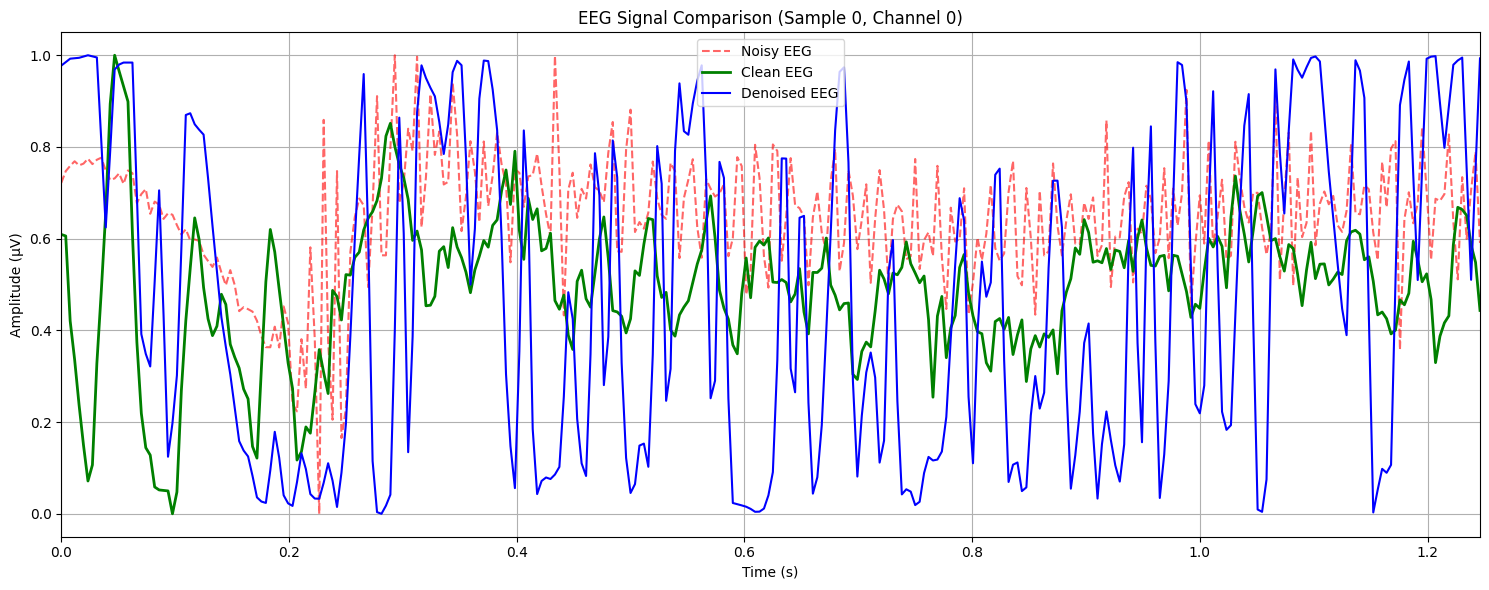

In [26]:
# evaluate_and_plot_noisy_clean(dataloader)
evaluate_and_plot(model, eval_dataloader, device, fs=256)